# Phase 3 Data Science Training Notebook

In [2]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras.datasets import cifar10
import matplotlib.pyplot as plt

## Exploratory Data Analysis

In [3]:
# Assume tar.gz file to be extracted at project directory.

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

### Opening the datasets.

In [4]:
data_batch_1 = unpickle('cifar-10-batches-py/data_batch_1')
data_batch_2 = unpickle('cifar-10-batches-py/data_batch_2')
data_batch_3 = unpickle('cifar-10-batches-py/data_batch_3')
data_batch_4 = unpickle('cifar-10-batches-py/data_batch_4')
data_batch_5 = unpickle('cifar-10-batches-py/data_batch_5')
test_batch = unpickle('cifar-10-batches-py/test_batch')

### Examining the datasets.

In [5]:
# Concatenate training datasets

data_batch_1_keys = data_batch_1.keys()
print(data_batch_1_keys)

train_labels = np.concatenate((data_batch_1[b'labels'], data_batch_2[b'labels'], data_batch_3[b'labels'], data_batch_4[b'labels'], data_batch_5[b'labels']), axis=0)
train_data = np.concatenate((data_batch_1[b'data'], data_batch_2[b'data'], data_batch_3[b'data'], data_batch_4[b'data'], data_batch_5[b'data']), axis=0)
train_filenames = np.concatenate((data_batch_1[b'filenames'], data_batch_2[b'filenames'], data_batch_3[b'filenames'], data_batch_4[b'filenames'], data_batch_5[b'filenames']), axis=0)

print(train_data.min(), train_data.max())

print(train_labels.shape)
print(train_data.shape)
print(train_filenames.shape)

# There are 50000 entries in a training label set and each entry is a category number.
# There are 50000 entries in a training image set. 

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
0 255
(50000,)
(50000, 3072)
(50000,)


In [6]:
# Reshaping the training dataset

train_data_reshape = train_data.reshape(len(train_data), 3, 32, 32).transpose(0,2,3,1)
print(train_data_reshape.shape)

#  Each entry in the training image set is assumed to take the 2D array shape of 28x28.

(50000, 32, 32, 3)


In [7]:
# Examining the testing dataset

test_batch_keys = test_batch.keys()
print(test_batch_keys)

test_batch_labels = np.array(test_batch[b'labels'])
test_batch_data = np.array(test_batch[b'data'])
test_batch_filenames = np.array(test_batch[b'filenames'])

print(test_batch_data.min(), test_batch_data.max())

print(test_batch_labels.shape)
print(test_batch_data.shape)
print(test_batch_filenames.shape)

test_batch_reshape = test_batch_data.reshape(len(test_batch_data), 3, 32, 32).transpose(0,2,3,1)

print(test_batch_reshape.shape)

# There are 10000 entries in the testing label set and each entry is a category number.
# There are 10000 entries in the testing image set and each entry is assumed to take the 2D array shape of 32x32.

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
0 255
(10000,)
(10000, 3072)
(10000,)
(10000, 32, 32, 3)


### Image Render

| Label | Description |
| --- | --- |
| 0 | airplane |
| 1 | automobile | 
| 2 | bird |
| 3 | cat |
| 4 | deer |
| 5 | dog |
| 6 | frog |
| 7 | horse |
| 8 | ship |
| 9 | truck |


In [8]:
np.unique(train_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

In [9]:
np.unique(test_batch_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

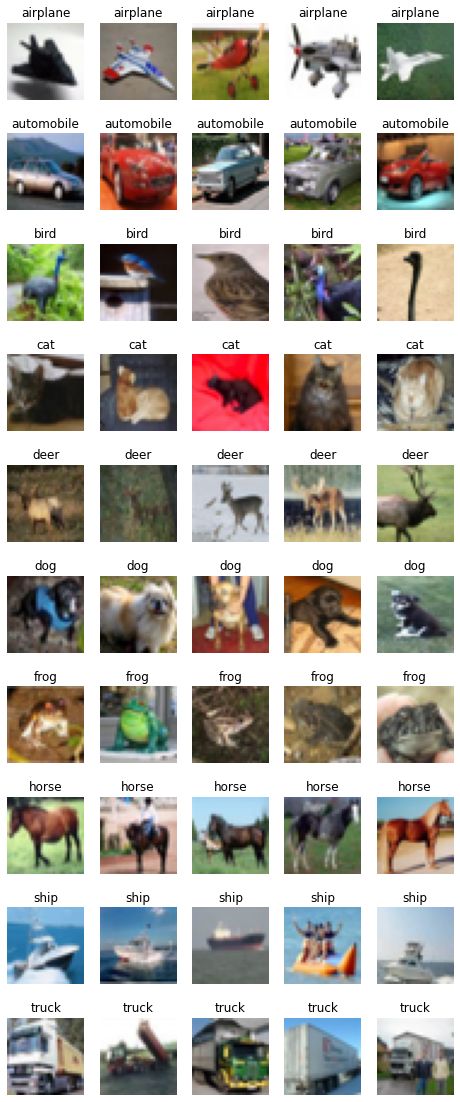

In [10]:
# Render 5 images from each label

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(8, 20))

for label in range(10): 
    search_results = np.where(train_labels == label)[0][:5]

    for index, img_index in enumerate(search_results):
        current_index = label * 5 + index + 1
        ax = plt.subplot(10,5, current_index)
        plt.imshow(train_data_reshape[img_index])
        plt.title(cifar_classes[label])
        plt.axis("off")

# Ensure I loaded the dataset correctly.

There is a good balance on the number of labelled images. The maximum value of the image is 255 and the minimum is 0. We can normalise the dataset to reduce the drasticness of the difference when the model is being trained. There are 3 colour layers so the images used here will be in RGB.

# Data Processing

The label I will be using for probability is `dog`, comparing with the `cat` label. 

In [11]:
# map label and image data together 
train_data_map = np.array(list(map(lambda x,y: (x,y), train_labels, train_data_reshape)), dtype=tuple)
test_data_map = np.array(list(map(lambda x,y: (x,y),test_batch_labels, test_batch_reshape)), dtype=tuple)

print("Training data shape:",train_data_map[0][0])
print("Testing data shape:",test_data_map.shape)

Training data shape: 6
Testing data shape: (10000, 2)


In [12]:
# 5 is the label for dog. I will convert the cat label as 0 and for is a dog for 1. 

train_label_filter = []
train_image_filter = []
test_label_filter = []
test_image_filter = []

for data in train_data_map:
    if data[0] == 5: # if label == 5; is dog
        train_label_filter += [1]
        train_image_filter += [data[1]]
    elif data[0] == 4: # if label == 4; is cat
        train_label_filter += [0]
        train_image_filter += [data[1]]

for data in test_data_map:
    if data[0] == 5: # if label == 5; is dog
        test_label_filter += [1]
        test_image_filter += [data[1]]
    elif data[0] == 4: # if label == 4; is cat
        test_label_filter += [0]
        test_image_filter += [data[1]]

print('Filtered train labels:', np.unique(train_label_filter, return_counts=True))
print('Filtered test labels:', np.unique(test_label_filter, return_counts=True))

# We now have a balanced training label dataset of 10000 entries. 5000 as cats and 5000 as dogs. 
# Same for the testing label dataset of 2000 entries. 1000 as cats and 1000 as dogs. 

Filtered train labels: (array([0, 1]), array([5000, 5000]))
Filtered test labels: (array([0, 1]), array([1000, 1000]))


In [13]:
# Shape of filtered data

print('Filtered train label shape:', np.shape(train_label_filter))
print('Filtered test label shape:', np.shape(test_label_filter))

print('Filtered image shape:', np.shape(train_image_filter))
print('Filtered image shape:', np.shape(test_image_filter))

Filtered train label shape: (10000,)
Filtered test label shape: (2000,)
Filtered image shape: (10000, 32, 32, 3)
Filtered image shape: (2000, 32, 32, 3)


In [14]:
# Convert lists to np array

train_x = np.array(train_image_filter)
test_x = np.array(test_image_filter)

train_y = np.array(train_label_filter)
test_y = np.array(test_label_filter)

# train_y = np.array([[int(i == label_index) for i in range(2)] for label_index in train_label_filter], dtype ='uint8')
# test_y = np.array([[int(i == label_index) for i in range(2)] for label_index in test_label_filter], dtype ='uint8')

In [15]:
# Ensure the y outputs is an array of 9 numbers labelled from 0 to 8 both inclusive.

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(10000, 32, 32, 3)
(10000,)
(2000, 32, 32, 3)
(2000,)


# Data Modelling

In [20]:
import tensorflow as tf
from tensorflow.keras import Input, layers, Sequential, optimizers, losses, callbacks, metrics
from datetime import datetime

In [21]:
def generateModel():
    """
    Make a Keras Sequential Model.
    Feel free to change the layout of the layers.

    Read more about keras here: https://keras.io/api/
    Tensorflow setup adapted here: https://www.tensorflow.org/tutorials/quickstart/beginner
    """
    model = Sequential(name="Image_Recognition_Model")
    model.add(Input(shape=(32,32,3))) # Input layer.

    model.add(layers.Rescaling(scale=1./255, name="Normaliser")) # Example pre-processing layer.


    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(10))
    

    model.add(layers.Dense(1, activation="sigmoid", name="Output_Probability")) # Output layer.


    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.00003),
        loss=losses.BinaryCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return model

In [23]:
model = generateModel()

model.summary()

Model: "Image_Recognition_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Normaliser (Rescaling)      (None, 32, 32, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 6

In [25]:
log_dir = "output/logs/" + datetime.now().strftime("%Y-%m-%d-%H:%M:%S")

# Callbacks for QoL.
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystop_callback = callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

history = model.fit(train_x, train_y,
    validation_data=(test_x, test_y),
    epochs=100,
    batch_size=1000, # Set this to a lower number if your computer spec is bad.
    callbacks=[tensorboard_callback, earlystop_callback],
    # verbose=0 # Uncomment this line to reduce the printing on console.
)

Epoch 1/100
10/10 [==============================] - 11s 1s/step - loss: 0.6914 - accuracy: 0.4996 - val_loss: 0.6888 - val_accuracy: 0.4975
Epoch 2/100
10/10 [==============================] - 11s 1s/step - loss: 0.6888 - accuracy: 0.5074 - val_loss: 0.6858 - val_accuracy: 0.5000
Epoch 3/100
10/10 [==============================] - 13s 1s/step - loss: 0.6843 - accuracy: 0.5306 - val_loss: 0.6835 - val_accuracy: 0.5190
Epoch 4/100
10/10 [==============================] - 13s 1s/step - loss: 0.6823 - accuracy: 0.5467 - val_loss: 0.6809 - val_accuracy: 0.5315
Epoch 5/100
10/10 [==============================] - 10s 993ms/step - loss: 0.6788 - accuracy: 0.5465 - val_loss: 0.6781 - val_accuracy: 0.5405
Epoch 6/100
10/10 [==============================] - 10s 996ms/step - loss: 0.6761 - accuracy: 0.5593 - val_loss: 0.6749 - val_accuracy: 0.5705
Epoch 7/100
10/10 [==============================] - 12s 1s/step - loss: 0.6719 - accuracy: 0.5814 - val_loss: 0.6713 - val_accuracy: 0.5890
Epoch 8

In [26]:
model.save('output/my_model')

INFO:tensorflow:Assets written to: output/my_model/assets


INFO:tensorflow:Assets written to: output/my_model/assets


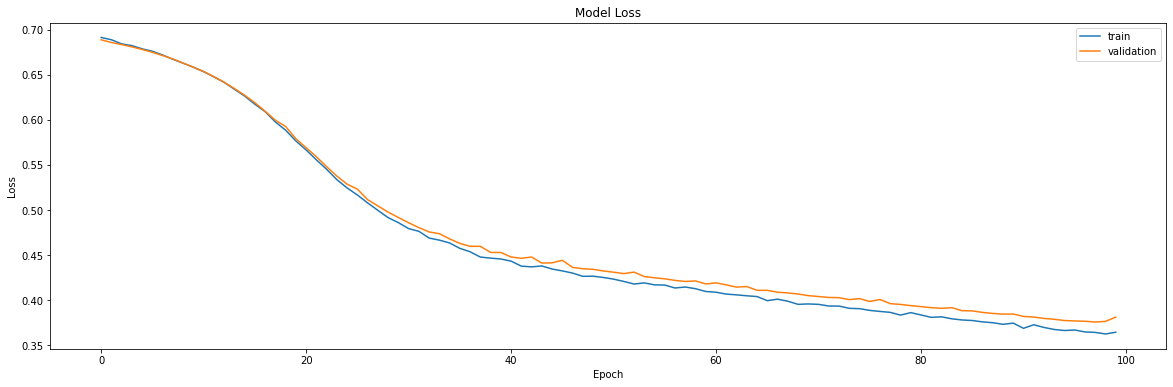

In [27]:
def plotLosses(history): 
    plt.figure(figsize=(20,6)) 
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

plotLosses(history)

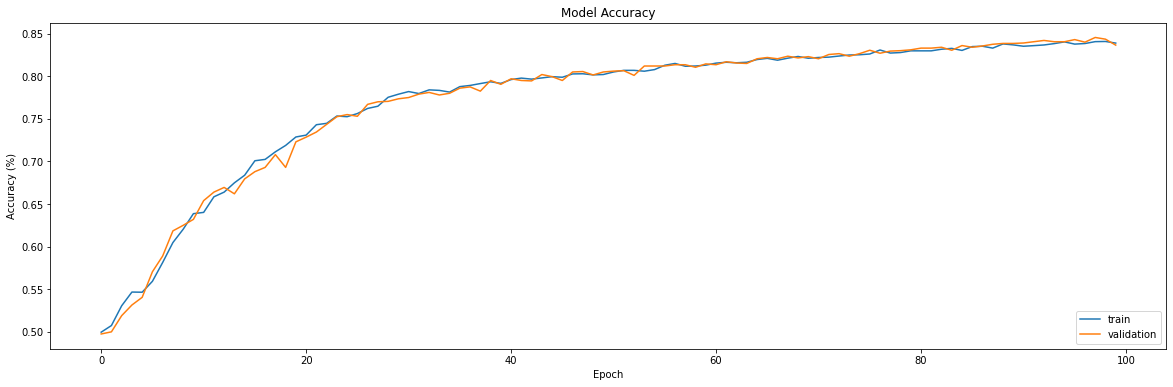

In [28]:
def plotAccuracy(history):
    plt.figure(figsize=(20,6))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()
    
plotAccuracy(history)

In [29]:
score = model.evaluate(test_x, test_y, batch_size=100, verbose=0)
print(model.metrics_names)
print(score)

['loss', 'accuracy']
[0.3810979723930359, 0.8364999890327454]


# Hyperparameter Tuning

We will add hyperparameter tuning to our model to optimise the accuracy. We will tune the following:

* Number of units in the first dense layer
* Dropout rate in the dropout layer
* Optimizer learning rate

In [48]:
from tensorboard.plugins.hparams import api as hp

In [52]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([32, 64]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('learning_rate', hp.Discrete([0.00003, 0.00004]))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('output/logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [53]:
def train_test_model(hparams):


  model2 = Sequential(name="Image_Recognition_Model")

  model2.add(Input(shape=(32,32,3))) # Input layer.

  model2.add(layers.Rescaling(scale=1./255, name="Normaliser")) # Example pre-processing layer.


  model2.add(layers.Conv2D(32, (3, 3), activation='relu'))
  model2.add(layers.MaxPooling2D((2, 2)))
  model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model2.add(layers.MaxPooling2D((2, 2)))
  model2.add(layers.Conv2D(64, (3, 3), activation='relu'))

  model2.add(layers.Flatten())
  model2.add(layers.Dense(hparams[HP_NUM_UNITS], activation='relu'))
  model2.add(layers.Dropout(hparams[HP_DROPOUT]))
  model2.add(layers.Dense(10))
    

  model2.add(layers.Dense(1, activation="sigmoid", name="Output_Probability")) # Output layer.
  

  model2.compile(
    optimizer=optimizers.Adam(learning_rate=hparams[HP_OPTIMIZER]),
    loss=losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
  )

  model2.fit(train_x, train_y, 
    validation_data=(test_x, test_y),
    epochs=10, # Run with 10 epochs to speed things up 
    batch_size=1000,
    callbacks=[
      tf.keras.callbacks.TensorBoard('output/logdir'),  # log metrics
      hp.KerasCallback('output/logdir', hparams), # log hparams
    ],  
  ) 
  _, accuracy = model2.evaluate(test_x, test_y)

  return accuracy

In [54]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [56]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('output/logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

--- Starting trial: run-0
{'num_units': 32, 'dropout': 0.1, 'learning_rate': 3e-05}
Epoch 1/10
10/10 [==============================] - 26s 2s/step - loss: 0.6959 - accuracy: 0.5005 - val_loss: 0.6923 - val_accuracy: 0.5175
Epoch 2/10
10/10 [==============================] - 10s 986ms/step - loss: 0.6907 - accuracy: 0.5120 - val_loss: 0.6887 - val_accuracy: 0.5030
Epoch 3/10
10/10 [==============================] - 12s 1s/step - loss: 0.6879 - accuracy: 0.5014 - val_loss: 0.6862 - val_accuracy: 0.4980
Epoch 4/10
10/10 [==============================] - 13s 973ms/step - loss: 0.6856 - accuracy: 0.5037 - val_loss: 0.6840 - val_accuracy: 0.5020
Epoch 5/10
10/10 [==============================] - 9s 939ms/step - loss: 0.6831 - accuracy: 0.5105 - val_loss: 0.6817 - val_accuracy: 0.5085
Epoch 6/10
10/10 [==============================] - 11s 1s/step - loss: 0.6808 - accuracy: 0.5161 - val_loss: 0.6790 - val_accuracy: 0.5105
Epoch 7/10
10/10 [==============================] - 11s 1s/step - lo

# Python Function to evaluate a given image.

In [262]:
import cv2

In [277]:

# function which takes in an image and returns if it is a dog
def is_this_a_dog(image_path):
    dim = (32, 32)
    threshold = 0.8

    # read the image
    read_image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(read_image, cv2.COLOR_BGR2RGB)
    # plt.imshow(image)
    print('Original Dimensions : ',image.shape)

    # resize image to be 32 x 32
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    print('Resized Dimensions : ',resized.shape)
    cv2.imshow("Resized image", resized)
    plt.imshow(resized)

    # predict if it is a dog
    probability = model.predict(np.array([resized]))
    print("The model's prediction if this is a dog:", probability[0][0])

    if probability > threshold:
        print("so it's probably a dog")
    else:
        print("so it's probably not a dog")


Original Dimensions :  (256, 256, 3)
Resized Dimensions :  (32, 32, 3)
1/1 [==============================] - 0s 51ms/step
The model's prediction if this is a dog: 0.9853211
so it's probably a dog


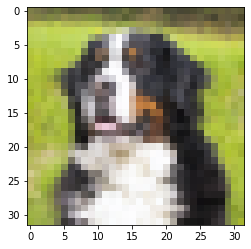

In [278]:
# image_path = 'img/cat_test_1.jpeg' # returns is not a dog :)
# image_path = 'img/cat_test_2.jpeg' # returns not a dog :)
# image_path = 'img/cat_test_3.jpeg' # returns not a dog :)
# image_path = 'img/dog_test_1.png' # returns not a dog :( sad doge 
# image_path = 'img/dog_test_2.png' # is a dog :)
# image_path = 'img/dog_test_3.jpeg' # is a dog :)
# image_path = 'img/dog_test_4.jpeg' # not a dog :( 
image_path = 'img/dog_test_5.jpeg' # returns is a dog :) 


is_this_a_dog(image_path)